# Natural Language Processing (NLP) for Information Retrieval

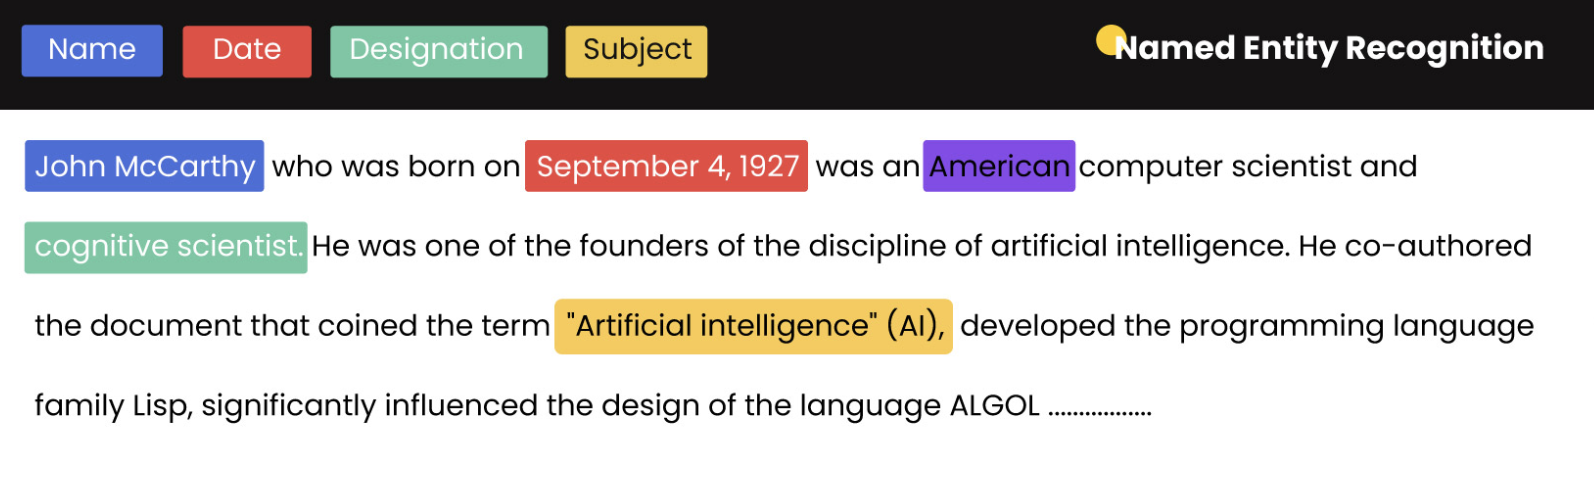

## Disclaimer

-----------------------------------------------------------------------------------------
**This data science notebook is provided for educational purposes only.**

It contains code, analysis, and models that are intended to serve as learning materials and examples. The content is not intended for direct deployment to production environments.

You are encouraged to adapt and modify the contents of this notebook in accordance with the license provided in the associated github repository. However, it is essential to exercise caution, further development, and thorough testing before considering any deployment to production systems.

The authors and contributors of this notebook assume no liability for any consequences, including financial or operational, resulting from the use or misuse of the information and code provided herein. Always consult with appropriate experts and conduct rigorous testing and validation before applying any techniques or models in a real-world, production context.

**By using this notebook, you agree to these terms and conditions.**

## Content

In this module we will be looking at NLP models, which can be used to retrieve data from text. As an example, let us consider a set of text related to consumer complaints. We will look at this data and identify keywords within them and the entity level information embedded in it. We will also look at extracting similar information from PDFs.

## Defining our target

Extract Keywords and Entity information (such as Organizations, People, Locations etc.) from text

Models: Spacy, KeyBert, Yake

## Loading data stored in csv format

Firstly, let us load a csv file that contains the first 10,000 rows of complaints found in a dataset complied by the United States Government on consumer complaints related to financial authorities

We will first import the pandas library to read the csv and at the same time store it as pandas data frame object

In [13]:
import pandas as pd
df = pd.read_csv('complaints_csv.csv')
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2/17/24,Student loan,Federal student loan servicing,Improper use of your report,Credit inquiries on your report that you don't...,NaN,Company believes it acted appropriately as aut...,MOHELA,NV,89178,NaN,Consent not provided,Web,2/17/24,Closed with explanation,Yes,NaN,8359670
1,2/20/24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,SC,29407,NaN,Other,Web,2/20/24,Closed with explanation,Yes,NaN,8379853
2,2/20/24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,"These inquiries do not pertain to me, and I di...",Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IL,60653,NaN,Consent provided,Web,2/20/24,Closed with non-monetary relief,Yes,NaN,8379478
3,2/18/24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,GA,310XX,NaN,Other,Web,2/18/24,Closed with non-monetary relief,Yes,NaN,8370653
4,2/29/24,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,14305,NaN,Consent not provided,Web,2/29/24,Closed with non-monetary relief,Yes,NaN,8438736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,3/27/24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,34109,NaN,NaN,Web,3/27/24,In progress,Yes,NaN,8627704
9995,4/10/24,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,"EQUIFAX, INC.",CA,90015,NaN,NaN,Web,4/10/24,In progress,Yes,NaN,8739495
9996,4/16/24,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85015,NaN,NaN,Web,4/16/24,In progress,Yes,NaN,8784815
9997,4/16/24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",IL,60411,NaN,NaN,Web,4/16/24,In progress,Yes,NaN,8784881


As you can see this dataset is rich with information such as the product the complaint was about sub-product, issue, sub-issue etc. Let us next determine all of columns (information) that we are actually storing for each instance (row)

In [14]:
list(df.columns)

['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Consumer complaint narrative',
 'Company public response',
 'Company',
 'State',
 'ZIP code',
 'Tags',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company',
 'Company response to consumer',
 'Timely response?',
 'Consumer disputed?',
 'Complaint ID']

## Identifying the actual complaints narrative

However, let us consider a more realistic scenario where we are receiving a complaint, via a web portal, email etc. that only includes text data. Thus, we will drop all rows where the ‘Consumer complaint narrative’ column is not filled (marked as NaN)

In [15]:
df = df.dropna(subset = ['Consumer complaint narrative'])
df = df.reset_index(drop=True)
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2/20/24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,"These inquiries do not pertain to me, and I di...",Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IL,60653,NaN,Consent provided,Web,2/20/24,Closed with non-monetary relief,Yes,NaN,8379478
1,2/20/24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,I'm experiencing immense stress and sleepless ...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IL,60517,NaN,Consent provided,Web,2/20/24,Closed with explanation,Yes,NaN,8380198
2,2/12/24,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,I checked my credit report and found that some...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,331XX,NaN,Consent provided,Web,2/12/24,Closed with non-monetary relief,Yes,NaN,8328541
3,2/12/24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Personal information incorrect,I have a goal of getting a house as soon as po...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,XXXXX,NaN,Consent provided,Web,2/12/24,Closed with non-monetary relief,Yes,NaN,8328922
4,2/20/24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,I've consistently made payments on time for th...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IL,60431,NaN,Consent provided,Web,2/20/24,Closed with explanation,Yes,NaN,8380536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,4/1/24,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Fraud or scam,NaN,On XX/XX/2024 I received a text message from W...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,FL,32960,Older American,Consent provided,Web,4/1/24,Closed with explanation,Yes,NaN,8672721
226,3/30/24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,this agency is not reporting accurate informat...,Company has responded to the consumer and the ...,CORELOGIC INC,WA,98030,NaN,Consent provided,Web,3/30/24,Closed with explanation,Yes,NaN,8661715
227,3/30/24,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,REMOVE / DELETE all CREDCO / XXXX XXXX ( XX/XX...,Company has responded to the consumer and the ...,CORELOGIC INC,TX,77338,NaN,Consent provided,Web,3/30/24,Closed with explanation,Yes,NaN,8655092
228,3/29/24,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt is not yours,"XXXX FCRA, XXXX has not provided validation or...",Company disputes the facts presented in the co...,Reliant Financial Corporation,WA,980XX,NaN,Consent provided,Web,3/29/24,Closed with explanation,Yes,NaN,8655723


From this particular dataset we observe that there are only 230 rows (complaints), which include a consumer complaint narrative. Let us isolate these ones and store the actual complaint text in data frame object for analysis. We wil create a data frame object that only contains these 230 narratives (text instances)

## Augmenting the narrative

You will have noticed that is a clean and pre-processed data set where for example the company and product the compliant was about. Let us assume a scenario where this was not the case, and this information was embedded within the complaint narrative in normal text. We will next add this information in.

First lets add to the complaints narrative the infromation about the product and the issue raised.

In [16]:
for i in range(230):
    df.iat[i, 5] = df.iat[i, 5] + " " +df.iat[i, 1] + "." + " " +df.iat[i, 3] + "."

Lets test this by looking at the new augmented complaints narrative for row 0

In [17]:
df.iat[0, 5]

'These inquiries do not pertain to me, and I did not authorize them. I request their immediate removal from my credit report. Credit reporting or other personal consumer reports. Incorrect information on your report.'

As you can see the text we wanted has been added to the complaints narrative

Next we will create some text to embedd the company infromation

In [18]:
for i in range(230):
    df.iat[i, 5] += " This complaint pertains to the company " + df.iat[i, 7]

The new narrative for this example now looks like this

In [19]:
df.iat[0, 5]

'These inquiries do not pertain to me, and I did not authorize them. I request their immediate removal from my credit report. Credit reporting or other personal consumer reports. Incorrect information on your report. This complaint pertains to the company Experian Information Solutions Inc.'

Now we are ready to start using our models to analyze this text examples. First let us create a new database with only the augmented complaints narrative column

In [20]:
df = df['Consumer complaint narrative']
df

0      These inquiries do not pertain to me, and I di...
1      I'm experiencing immense stress and sleepless ...
2      I checked my credit report and found that some...
3      I have a goal of getting a house as soon as po...
4      I've consistently made payments on time for th...
                             ...                        
225    On XX/XX/2024 I received a text message from W...
226    this agency is not reporting accurate informat...
227    REMOVE / DELETE all CREDCO / XXXX XXXX ( XX/XX...
228    XXXX FCRA, XXXX has not provided validation or...
229    FALSE INQUIRES LISTED ON CONSUMER REPORT ( NO ...
Name: Consumer complaint narrative, Length: 230, dtype: object

Let’s look at the first 5 complaint narratives and the data type they are stored in

In [21]:
for i in range(0,5):
    print(df[i])
    print('data type =',type(df[i]))
    print('__________________')

These inquiries do not pertain to me, and I did not authorize them. I request their immediate removal from my credit report. Credit reporting or other personal consumer reports. Incorrect information on your report. This complaint pertains to the company Experian Information Solutions Inc.
data type = <class 'str'>
__________________
I'm experiencing immense stress and sleepless nights because of this problem. It's frustrating because I've always been punctual with my payments for this account. Credit reporting or other personal consumer reports. Incorrect information on your report. This complaint pertains to the company Experian Information Solutions Inc.
data type = <class 'str'>
__________________
I checked my credit report and found that some of the data were incorrect. The three credit bureaus are required by Sections 609 ( a ) ( 1 ) ( A ) and 611 ( a ) ( 1 ) to verify these accounts ( A ). It is not permitted to report these accounts as unverified information without giving any 

## Extracting keywords from text using YAKE

Now that we have the over 230 augmented instances of complaints text. Let us use YAKE for this task

In [89]:
import yake

### Yake Keyword Extraction

In [93]:
import pprint

In [94]:
kw_extractor = yake.KeywordExtractor() #intialize the keyword extractor

language = "en" #you can set the language of the text here. For example, for German use language=’de'
max_ngram_size = 3 #The max n-gram size sets an upper limit on how many words a keyword can consist of
deduplication_threshold = 0.9 #The de-duplication threshold limits duplicate words withing the differnt keywords
#setting this to 0.1 will mean no duplicate words are allowed within different keywords, 0.9 means duplication is allowed
numOfKeywords = 1 # Set an upper limit on the number of keywords to be extracted

# Next we initialize the extractor with the above set variables/limitations
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords_main = {}
for i in range(0,len(df)):
    top_word = []
    keywords = custom_kw_extractor.extract_keywords(df[i]) #get the keywords from each instance
    for kw in keywords: #loop through
       top_word.append(kw)
    keywords_main[i] = top_word

### Single keyword extraction

We will now take a look at the first complaint narrative and the key word extracted for it

In [95]:
df.iat[0]

'These inquiries do not pertain to me, and I did not authorize them. I request their immediate removal from my credit report. Credit reporting or other personal consumer reports. Incorrect information on your report. This complaint pertains to the company Experian Information Solutions Inc.'

In [96]:
keywords_main[0]

[('Experian Information Solutions', 0.19167186110590317)]

Since this complaint is regarding Experian this is the main keyword the algorithm identifies

However if we look at the second complaint in a similar fashion

In [100]:
df.iat[1]

"I'm experiencing immense stress and sleepless nights because of this problem. It's frustrating because I've always been punctual with my payments for this account. Credit reporting or other personal consumer reports. Incorrect information on your report. This complaint pertains to the company Experian Information Solutions Inc."

In [101]:
keywords_main[1]

[('experiencing immense stress', 0.01217876500951645)]

We find that the algorithm identifies the term ‘experiencing immense stress’ as the keyword. This is because this model is trained to understand the semantic meaning of the whole text and has decided that the fact that the complainant being under extreme stress is more important than who the complaint was about. Thus, during keyword extraction it is often beneficial to extract the top 3-5 keywords to tag that body of text and extract more meaningful and diverse information. 

### Multiple keyword extraction

Next let us use YAKE to identify the top 5 keywords for each of the complaint narratives

In [116]:
language = "en" #you can set the language of the text here. For example, for German use language=’de'
max_ngram_size = 3 #The max n-gram size sets an upper limit on how many words a keyword can consist of
deduplication_threshold = 0.5 #The de-duplication threshold limits duplicate words withing the differnt keywords
#setting this to 0.1 will mean no duplicate words are allowed within different keywords, 0.9 means duplication is allowed
numOfKeywords = 5 # Set an upper limit on the number of keywords to be extracted

# Next we initialize the extractor with the above set variables/limitations
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords_main = {}
for i in range(0,len(df)):
    top_word = []
    keywords = custom_kw_extractor.extract_keywords(df[i]) #get the keywords from each instance
    for kw in keywords: #loop through
       top_word.append(kw)
    keywords_main[i] = top_word

In [117]:
keywords_main[1]

[('experiencing immense stress', 0.01217876500951645),
 ('stress and sleepless', 0.05092874354751947),
 ('sleepless nights', 0.05092874354751947),
 ('problem', 0.15301461946725423),
 ('Experian Information Solutions', 0.15441564361868595)]

In [118]:
df[1]

"I'm experiencing immense stress and sleepless nights because of this problem. It's frustrating because I've always been punctual with my payments for this account. Credit reporting or other personal consumer reports. Incorrect information on your report. This complaint pertains to the company Experian Information Solutions Inc."

As you can see Experian Information Solutions is now extracted a keyword, furthermore the number attached to keyword is the value given for its importance. The larger the number the more importantance is given to that keyword

If we wanted to print all the top keywords for all complaints we can run the below code

In [119]:
for i in range(0,230):
    pprint.pprint((keywords_main[i][4]))

('information', 0.2732084143843116)
('Experian Information Solutions', 0.15441564361868595)
('required by Sections', 0.11746848864638307)
('goal', 0.23251748882352907)
('account', 0.17267761121376088)
('credit reporting agency', 0.025913162791638602)
('reporting agency found', 0.025066551744489515)
('card', 0.14585380195881384)
('Frivolous or Irrelevant', 0.06533748373375944)
('month of XXXX', 0.22317815564201507)
('inconsistent information', 0.056793175798977184)
('information', 0.02758417140920595)
('act XXXX', 0.006217899423982563)
('fraudulent accounts', 0.0494615335019768)
('XXXX', 0.01191279513973252)
('information', 0.057317224134322005)
('items', 0.0786372967852845)
('information', 0.2639151100515051)
('Called Title max', 0.08613599464566819)
('accounts', 0.30641025189367593)
('fraudulent charges', 0.06990295074431267)
('credit report', 0.13962881638338495)
('LIVING PERSON', 0.020088162142349764)
('XXXX', 0.04827233120174489)
('Bureaus a month', 0.09147963358446126)
('credit', 

Keyword extraction can be thought of as unsupervised topic modelling. You can observe that this dataset is anonymized, so the extractor finds the most important keyword even if it is blanked out using ‘X’ notation. You can also experiment with some of the parameters. The max n-gram size sets an upper limit on how many words a keyword can consist of, The de-duplication threshold limits duplicate words within the differnt keywords extracted for the same text. 

## KeyBERT

We can also use a LLM such BERT, which has already been trained for key word extraction in a similar way to Yake. Let us set this up and run it on our dataset.

In [122]:
from keybert import KeyBERT #import the package
kw_model = KeyBERT() #intialize the extractor

As before let us, as an example, look at the top 5 keywords extracted for the first complain and compare the results to YAKE. First lets remind ourselves of the text of the complaint.

### Single and multiple keyword extraction

In [125]:
df[0]

'These inquiries do not pertain to me, and I did not authorize them. I request their immediate removal from my credit report. Credit reporting or other personal consumer reports. Incorrect information on your report. This complaint pertains to the company Experian Information Solutions Inc.'

In [131]:
keywords = kw_model.extract_keywords(df[0],keyphrase_ngram_range=(1, 3),stop_words='english',highlight=False,top_n=5)
keywords

[('information report complaint', 0.5862),
 ('removal credit report', 0.5652),
 ('inquiries pertain did', 0.5357),
 ('credit report', 0.5275),
 ('credit reporting', 0.5178)]

The same result for yake is as follows:

In [127]:
keywords_main[0]

[('Experian Information Solutions', 0.19167186110590317),
 ('report', 0.23291911678822838),
 ('inquiries', 0.26419768152089734),
 ('authorize', 0.26419768152089734),
 ('information', 0.2732084143843116)]

As you may observe KeyBERT is able to ascertain that the report is regarding a credit report, which Yake missed.

What about the second complaint where Yake really focused on the complainant being under stress as the main issue. The complaint was as follows:

In [132]:
df[1]

"I'm experiencing immense stress and sleepless nights because of this problem. It's frustrating because I've always been punctual with my payments for this account. Credit reporting or other personal consumer reports. Incorrect information on your report. This complaint pertains to the company Experian Information Solutions Inc."

For KeyBERT the top 5 keywords are:

In [133]:
keywords = kw_model.extract_keywords(df[1],keyphrase_ngram_range=(1, 3),stop_words='english',highlight=False,top_n=5)
keywords

[('account credit reporting', 0.6306),
 ('information report complaint', 0.5837),
 ('credit reporting', 0.5795),
 ('credit reporting personal', 0.5527),
 ('payments account credit', 0.5372)]

Whereas for Yake:

In [135]:
keywords_main[1]

[('experiencing immense stress', 0.01217876500951645),
 ('stress and sleepless', 0.05092874354751947),
 ('sleepless nights', 0.05092874354751947),
 ('problem', 0.15301461946725423),
 ('Experian Information Solutions', 0.15441564361868595)]

KeyBERT has again focused and identified that the main purpose of the complaint is regarding credit reporting, while Yake fails to do so. This is because it is a LLM and can understand the syntactic and semantic meaning of the whole text and identify the keyword for it. We can run KeyBERT to identify all the complaints using this for loop (note: the runtime is around 5 mins since we are using a LLM without GPUs and parralel computing):

In [137]:
from time import time

In [140]:
# The following code takes around 280 seconds to run on Data Gym
t0 = time()
kbert_keywords = []
for i in range(0,230):
    keywords = kw_model.extract_keywords(df[i],keyphrase_ngram_range=(1, 3),stop_words='english',highlight=False,top_n=5)
    kbert_keywords.append(keywords)
print('Time Taken to Run Code: ',time()-t0)

Time Taken to Run Code:  277.63568139076233


We can then access the top keywords for each complaint, lets do this for the top 20 complaints

In [144]:
for i in range(0,20):
    pprint.pprint(kbert_keywords[i][0])

('information report complaint', 0.5862)
('account credit reporting', 0.6306)
('incorrect credit bureaus', 0.6608)
('credit reporting personal', 0.6082)
('incorrect late payment', 0.6897)
('credit bureaus errors', 0.6971)
('credit bureaus errors', 0.6921)
('credit xxxx citi', 0.6214)
('information disputed consumer', 0.6473)
('bureau reports late', 0.7207)
('inconsistent information account', 0.6264)
('furnisher information credit', 0.6059)
('credit reporting act', 0.5901)
('report noticed fraudulent', 0.6849)
('debt collector lnvl', 0.6694)
('consumer report violation', 0.6627)
('fraudulent items credit', 0.6185)
('complaint falsely reporting', 0.6697)
('obtained title loan', 0.6379)
('credit reports inaccurate', 0.7905)


If we compare this against Yake for the same 20 complaints

In [145]:
for i in range(0,20):
    pprint.pprint((keywords_main[i][4]))

('information', 0.2732084143843116)
('Experian Information Solutions', 0.15441564361868595)
('required by Sections', 0.11746848864638307)
('goal', 0.23251748882352907)
('account', 0.17267761121376088)
('credit reporting agency', 0.025913162791638602)
('reporting agency found', 0.025066551744489515)
('card', 0.14585380195881384)
('Frivolous or Irrelevant', 0.06533748373375944)
('month of XXXX', 0.22317815564201507)
('inconsistent information', 0.056793175798977184)
('information', 0.02758417140920595)
('act XXXX', 0.006217899423982563)
('fraudulent accounts', 0.0494615335019768)
('XXXX', 0.01191279513973252)
('information', 0.057317224134322005)
('items', 0.0786372967852845)
('information', 0.2639151100515051)
('Called Title max', 0.08613599464566819)
('accounts', 0.30641025189367593)


It’s clear, if you compare the 2 results, that KeyBERT does a much better job at extracting keywords that make sense capture the main point of the complaints. That is because it is a LLM and has been trained on large amounts of data to understand the meaning behind words and sentences

## Named Entity Recognition (NER)

In this part of the module, we will be using a library for the task of Named Entity Recognition (NER). NER is NLP use case where we want to be able to automatically extract the names of corporation, people, locations etc. from a body of text like our complaints data. First let us import the required libraries.

In [ ]:
import spacy #import the package
from spacy import displacy 

### Extracting key infromation in text

We will then load the NER model and will use this longer text, which comes from an article on the BIS website on insurance supevision as an example

In [27]:
text = ("""Second Asia-Pacific high-level meeting on insurance supervision.
Senior insurance supervisors from Asia-Pacific, the fastest growing insurance market in the world,
met to discuss three key issues - technology, climate change and proportionate regulation.
This was the second meeting of its kind, bringing together over 50 senior officials from insurance authorities and companies.
The meeting was hosted by the Monetary Authority of Macao, and was jointly organized by the Asian Forum of Insurance Regulators (AFIR),
the Financial Stability Institute (FSI) of the Bank for International Settlements (BIS) and the International Association of Insurance Supervisors (IAIS).
As the global frontrunner in embracing technological developments both in the provision of insurance services and the use of technology by insurance authorities themselves,
the insurance industry in Asia-Pacific has the potential to revolutionize the insurance sector and the way supervision is conducted.
In this regard, the meeting exchanged views on fintech sandboxes, technology used for supervision (suptech) and importantly, cyber security resilience frameworks.
The devastating human and economic impact of climate change on increasingly urbanized populations in this region is clear.
The time has come to go beyond raising awareness of risks arising from climate change. Supervisors in the region and indeed globally 
are taking concrete actions to address climate change risks, in close partnership with the insurance industry.
The meeting noted concrete regulatory and supervisory measures that have been taken in two major jurisdictions in tackling these critically important risks. 
The meeting also discussed the different regulatory approaches in applying proportionate insurance solvency requirements.
With the forthcoming finalization of the global Insurance Capital Standard (ICS) by the IAIS, 
there could be further consideration in providing guidance on the proportionate application of such a standard.""")

In [28]:
NER = spacy.load("en_core_web_sm") #load the training data
output = NER(text) #run the model on the text and store the outputs

In [32]:
for word in output.ents: #iterate through the entities stored in he output
    print(word.label_,'-> ' + word.text) #print the word and corresponding label

LOC -> Asia-Pacific
LOC -> Asia-Pacific
CARDINAL -> three
ORDINAL -> second
CARDINAL -> 50
ORG -> the Monetary Authority of Macao
ORG -> the Asian Forum of Insurance Regulators
ORG -> the Financial Stability Institute
ORG -> the Bank for International Settlements
ORG -> BIS
ORG -> the International Association of Insurance Supervisors
LOC -> Asia-Pacific
CARDINAL -> two
ORG -> Insurance Capital Standard
ORG -> ICS
ORG -> IAIS


### Spacy Entity Types

Spacy has multiple entity types such as ORG for organizations and LOC for geographic location. Below are the full list of Spacy types along with their definitions

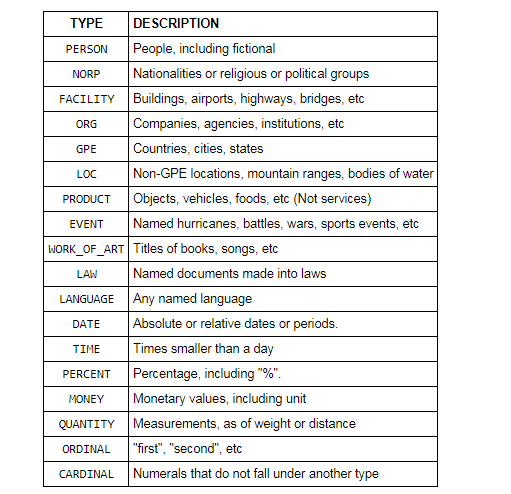

This dictionary is aggregated, and we can quickly look up for example all organizations mentioned in the text using the type (‘ORG’ for this example) from the spacy entity table

For this example, we are able to identify the organizations and locations mentioned in the text. We can also visualize this result. 

In [36]:
sentence_spans = list(output.sents)
displacy.render(sentence_spans, style="ent", jupyter=True)

### Storing the extracted information

We can also store this information in a python dictionary for quick lookup

In [39]:
from collections import defaultdict
dict_1 = defaultdict(list)

In [40]:
for word in output.ents: #iterate through the entities stored in the output
    dict_1[word.label_].append(word.text)

This This dictionary is aggregated, and we can quickly look up for example all organizations mentioned in the text using the type (‘ORG’ for this example) from the spacy entity table

In [42]:
dict_1['ORG']

['the Monetary Authority of Macao',
 'the Asian Forum of Insurance Regulators',
 'the Financial Stability Institute',
 'the Bank for International Settlements',
 'BIS',
 'the International Association of Insurance Supervisors',
 'Insurance Capital Standard',
 'ICS',
 'IAIS']

NER is a powerful tool, which can be leveraged to quickly extract entity level information from large bodies of text or from multiple instances of text. 

### NER on the complaints data

As an example we can run our model across all the complaints in our augmented data set and see which entity/entities each complaint is related to 

In [49]:
for i in range(0,len(df)):
    out = NER(df[i])
    dict_iter = defaultdict(list)
    for word in out.ents: #iterate through the entities stored in the output
        dict_iter[word.label_].append(word.text)
    print(dict_iter['ORG'])

['Experian Information Solutions Inc.']
['Experian Information Solutions Inc.']
['Sections 609', 'Experian Information Solutions Inc.']
['Experian Information Solutions Inc.']
['Experian Information Solutions Inc.']
['Credit Bureaus', 'Experian Information Solutions Inc.']
['Credit Bureaus', 'Experian Information Solutions Inc.']
['Citi', 'Citi', 'CITIBANK', 'N.A.']
['Obtaining', 'Experian Information Solutions Inc.']
['XXXX', 'XXXX', 'FCRA', 'Experian Information Solutions Inc.']
['Experian Information Solutions Inc.']
['the Fair Credit Reporting Act', 'USC', 'USC', 'Congress', 'USC', 'XXXX', 'USC', 'Experian Information Solutions Inc.']
['U.S.C', 'Experian Information Solutions Inc.']
['Experian Information Solutions Inc.']
['XXXX', 'Social Security', 'Resurgent Capital Services L.P.']
['USC', 'the Person/Corporation', 'USC', 'Collection/Charge-Off Status WITHOUT', 'IRS', 'USC', 'the Cancellation of Indebtedness By Certain Entities', 'IRS', 'IRS', 'the Internal Revenue Service', 'Exp

## Preparing for next steps¶

In this module we cover how NLP models, including LLM's can be used to quickly extract key information from multiple instances of text data, such as complaints. Both keyword extraction and NER can be invaluable in finding key insights about the data itself.

As next steps you might consider uploading your own text data and analyzing the results. Alternatively, you could look at module 2_7, which demonstrates how to extract the raw text from a pdf document and test the efficacy of keyword extraction and NER across multiple documents. 

2_7 also covers language translation so you could also extract the raw text from a PDF or use complaints data in another language and see how the translation model can be combined with these models to gather key insights.